In [169]:
import pandas as pd
import datetime
import numpy as np
from google.colab import files 
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['ecommerce_data.csv']))
# Here choose the 'ecommerce_data.csv' from the local machine.

Saving ecommerce_data.csv to ecommerce_data.csv


### Here the selection of the prediction type and EStore are done. 

In [262]:
# selection = 1 is for predicting total amount of Sales for the future dates, 
# selection = 0 is for predicting the transactions for the future dates.
selection = 0 # adjust this line depending on your decision. 

### Estores are numbered from 1 to 32. the rest of the code works independently.
test_e_store = 1 # adjust this line depending on your decision

## E stores are split because each store have different personality. 
## E.g. Christmas tree store won't have similar traffic trends to the Bread Seller.

In [263]:
# Checking the data.
df.head()

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,InvoiceDate.1,UnitPrice,CustomerID,Country,Estore_id
0,2010-12-09 15:43:00,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1.0,2010-12-09 15:43:00,2.95,15329.0,United Kingdom,20
1,2011-12-09 09:07:00,581480,23355,HOT WATER BOTTLE KEEP CALM,12.0,2011-12-09 09:07:00,4.95,14441.0,United Kingdom,20
2,2011-12-07 12:55:00,581132,NaN,NaN,4.0,2011-12-07 12:55:00,4.95,17590.0,United Kingdom,1
3,2011-06-23 14:11:00,557892,NaN,NaN,2.0,2011-06-23 14:11:00,6.35,14534.0,United Kingdom,17
4,2011-01-25 14:01:00,542115,84992,NaN,1.0,2011-01-25 14:01:00,2.08,NaN,United Kingdom,6


In [264]:
# further investigation on the Data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130000 entries, 0 to 129999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   InvoiceDate    130000 non-null  object 
 1   InvoiceNo      130000 non-null  object 
 2   StockCode      6646 non-null    object 
 3   Description    3693 non-null    object 
 4   Quantity       10426 non-null   float64
 5   InvoiceDate.1  130000 non-null  object 
 6   UnitPrice      130000 non-null  float64
 7   CustomerID     125418 non-null  float64
 8   Country        130000 non-null  object 
 9   Estore_id      130000 non-null  int64  
dtypes: float64(3), int64(1), object(6)
memory usage: 9.9+ MB


### Data Engineering Happens Here

In [265]:
data = df[df.Estore_id == test_e_store]

## For simplicity purposes, We only keep the used columns, later you can try to add columns to provide value.
# Dropping duplicate or useless columns
data = data.drop(columns=[
                          'InvoiceDate.1','StockCode',
                          'InvoiceNo','Description',
                          'CustomerID','Country'
                          ])

# Reducing the complexity of the Date column by limiting it to a day precision.
data['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.ceil(freq='D')

## If Qauntity is not declared, 1 is used as fillment.
# As it is sensible, and the most common value in the field. 
data['Quantity'] = data['Quantity'].fillna(1.0)

# Adding a new column for the Business purpose of this task.
data['tot_sale_value'] = data['Quantity'] * data['UnitPrice']

data = data.sort_values(by='InvoiceDate')
data.head() # Checking the result

,InvoiceDate,Quantity,UnitPrice,Estore_id,tot_sale_value
106317,2010-12-02,1.0,1.65,1,1.65
104031,2010-12-02,1.0,1.95,1,1.95
104319,2010-12-02,1.0,0.42,1,0.42
26151,2010-12-02,1.0,3.75,1,3.75
90736,2010-12-02,1.0,1.25,1,1.25


In [269]:
## Engineering/ Aggregating the raw data further for simplicity.
df1 = data

if selection == 1:
  ### Option 2: Sum of the same day transactions. (In time series, we want to see data points per each time step. Not for each occurence.)
  df1 = df1.groupby(by='InvoiceDate', as_index=False)['tot_sale_value'].sum()
else:
  ### Option 1: the total count of transactions 
  df1 = df1[df1.Quantity != 0].groupby(by='InvoiceDate', as_index=False)['tot_sale_value'].count()

### Standardization of the dates by inserting the missing ones.
min_max_dates = pd.DataFrame()
min_max_dates['InvoiceDate'] = pd.date_range(data['InvoiceDate'].min(), data['InvoiceDate'].max())
df1 = df1.merge(min_max_dates, how='right', on=['InvoiceDate'])

### Filling the values for non-active days...
df1['tot_sale_value'] = df1['tot_sale_value'].fillna(0)

### Rolling mean for simple & less jumpy data points. (plot for proof on next cell)
df1['tot_sale_valueRoll'] = df1['tot_sale_value'].rolling(3,center=True).mean().round()

### Keeping only the related columns. & adjusting the shape of dataframe after grouping/rolling.
df1.columns = ['InvoiceDate', 'tot_sale_value','tot_sale_valueRoll']

### Creating the columns which tells about the past, to be used in the training/predicting.  
training_columns = []
n_historical_data_points = 15 # adjustable
for i in range(1,n_historical_data_points+1):
  col_name = "Lag_{}".format(i)
  training_columns.append(col_name)
  df1[col_name] = df1['tot_sale_valueRoll'].shift(i)

### Avoiding the records with null values
df1 = df1.dropna().reset_index()
df1.head(10)

,index,InvoiceDate,tot_sale_value,tot_sale_valueRoll,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15
0,16,2010-12-18,32.0,12.0,13.0,4.0,4.0,3.0,1.0,3.0,8.0,20.0,20.0,18.0,9.0,7.0,7.0,5.0,14.0
1,17,2010-12-19,0.0,11.0,12.0,13.0,4.0,4.0,3.0,1.0,3.0,8.0,20.0,20.0,18.0,9.0,7.0,7.0,5.0
2,18,2010-12-20,1.0,4.0,11.0,12.0,13.0,4.0,4.0,3.0,1.0,3.0,8.0,20.0,20.0,18.0,9.0,7.0,7.0
3,19,2010-12-21,11.0,10.0,4.0,11.0,12.0,13.0,4.0,4.0,3.0,1.0,3.0,8.0,20.0,20.0,18.0,9.0,7.0
4,20,2010-12-22,19.0,12.0,10.0,4.0,11.0,12.0,13.0,4.0,4.0,3.0,1.0,3.0,8.0,20.0,20.0,18.0,9.0
5,21,2010-12-23,5.0,10.0,12.0,10.0,4.0,11.0,12.0,13.0,4.0,4.0,3.0,1.0,3.0,8.0,20.0,20.0,18.0
6,22,2010-12-24,5.0,3.0,10.0,12.0,10.0,4.0,11.0,12.0,13.0,4.0,4.0,3.0,1.0,3.0,8.0,20.0,20.0
7,23,2010-12-25,0.0,2.0,3.0,10.0,12.0,10.0,4.0,11.0,12.0,13.0,4.0,4.0,3.0,1.0,3.0,8.0,20.0
8,24,2010-12-26,0.0,0.0,2.0,3.0,10.0,12.0,10.0,4.0,11.0,12.0,13.0,4.0,4.0,3.0,1.0,3.0,8.0
9,25,2010-12-27,0.0,0.0,0.0,2.0,3.0,10.0,12.0,10.0,4.0,11.0,12.0,13.0,4.0,4.0,3.0,1.0,3.0


<Figure size 432x288 with 0 Axes>

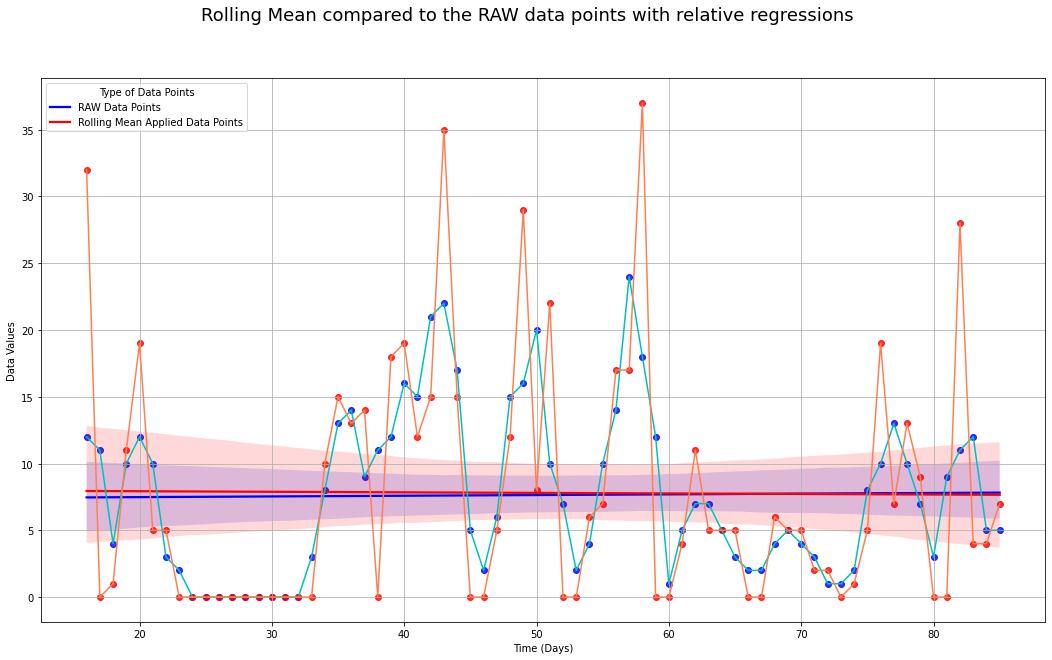

In [288]:
plt.clf();
plt.figure(figsize=(18,10))
plt.suptitle('Rolling Mean compared to the RAW data points with relative regressions', fontsize=18)
ax = sns.regplot(x='index', y='tot_sale_valueRoll', data=df1[:70], color='blue')
ax = sns.regplot(x='index', y='tot_sale_value', data=df1[:70], color='red')
ax = sns.lineplot(x='index', y='tot_sale_valueRoll', data=df1[:70], color='c')
ax = sns.lineplot(x='index', y='tot_sale_value', data=df1[:70], color='coral')
plt.ylabel("Data Values")
plt.xlabel("Time (Days)")

plt.legend(title='Type of Data Points', loc='upper left', labels=['RAW Data Points', 'Rolling Mean Applied Data Points'])

plt.grid()

plt.show();

### Machine Learning Related Work Happens Here

In [314]:
y_pred = None
model = None

# Training data prep.
X = df1.loc[:, training_columns]      # features
y = df1.loc[:, 'tot_sale_valueRoll']  # target

# Leaving some for double check and prediction plotting
X, X_unseen = X[:-20], X[-20:]
y, y_unseen = y[:-20], y[-20:]

# Splitting validation and training sets.
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)

# Train the model
model = RandomForestRegressor(n_estimators=10, criterion="absolute_error", random_state=1)
model.fit(train_x, train_y)

# Predictions (min prediction is limited at 0. As minus amount of transactions are not likely to happen)
y_pred = model.predict(test_x)
y_pred[y_pred<0] = 0

print("mean_absolute_error on validation data: {}".format(mean_absolute_error(y_pred, test_y)))
print("mean_squared_error on validation data: {} \n".format(mean_squared_error(y_pred, test_y)))

# Predictions (on the Unseen data)
y_pred_unseen = model.predict(X_unseen)
y_pred_unseen[y_pred_unseen<0] = 0

print("mean_absolute_error on unseen data: {}".format(mean_absolute_error(y_pred_unseen, y_unseen)))
print("mean_squared_error on unseen data: {}".format(mean_squared_error(y_pred_unseen, y_unseen)))

mean_absolute_error on validation data: 3.8514705882352946
mean_squared_error on validation data: 24.436323529411766 

mean_absolute_error on unseen data: 4.2299999999999995
mean_squared_error on unseen data: 23.487000000000002


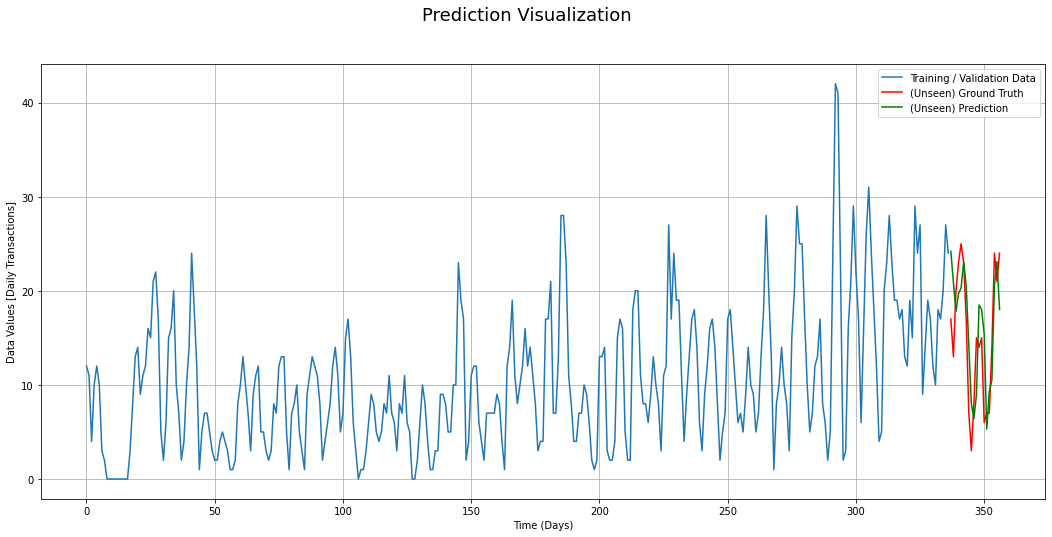

In [315]:
plt.figure(figsize=(18,8))

unseen_x_ticks = range(len(df1.loc[:, 'tot_sale_valueRoll']))[-20:]
seen_x_ticks = range(len(df1.loc[:, 'tot_sale_valueRoll']))[:-20]

plt.suptitle('Prediction Visualization', fontsize=18)
plt.plot(seen_x_ticks, y, label='Training / Validation Data')
plt.plot(unseen_x_ticks, y_unseen, 'red', label='(Unseen) Ground Truth')
plt.plot(unseen_x_ticks, y_pred_unseen, 'green', label='(Unseen) Prediction')
plt.grid()
plt.legend()
plt.ylabel("Data Values [{}]".format('Daily Transactions' if selection != 1 else 'Total Sale Value'))
plt.xlabel("Time (Days)")

plt.show();

In [ ]:
# Efe Ergun.